## Thermal Conductivity Fit Analysis
Developed by Henry Nachman

Last Edited: 19 February 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# note : most functions needed for running this notebook can be found in tc_utils.
from tc_utils import *

First, we need to find where all our RAW data is

In [2]:
path_to_lib = f"{os.getcwd()}\\lib"
mat_directories = [folder for folder in os.listdir(path_to_lib) if not folder.endswith(".md")]

path_to_RAW = dict()
for mat in mat_directories:
    raw_str = f"{path_to_lib}\\{mat}\\RAW"
    path_to_RAW[mat] = raw_str


print(path_to_RAW)

{'SS304': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS304\\RAW'}


This function will fit the data to polynomials. The fit is done in two stages, a low end fit and a high end fit. The two fits are then connected using an Error Function centered at the discontinuity.

In [3]:
def fit_thermal_conductivity(big_data, save_path, erf_loc = 20, fit_orders = (3,3), fit_types=("k/T", "loglog"), plots=False):
    """
    Arguments :
    - big_data   - Array of measurement data concatenated (should be of shape: [N, 3])
    - save_path  - File path to publish output files and plots.
    - erf_loc     - default=20    - Temperature at which to split the data for fitting (and to place the error function).
    - fit_orders - default=(3,3) - Polynomial fit order (low, high).
    - fit_types  - default=("k/T", "loglog") - defines the type of fit for each regime (low, high).
    - plots      - default=False - Boolean argument, if true, plots are made and saved to save_path.

    Returns :
    - arg_dict - Dictionary of fit arguments - includes low fit, high fit, and combined fit arguments.
    """
    # divide the data array into three columns
    T = big_data[:,0]
    k = big_data[:,1]
    koT = big_data[:,2]
    weights = big_data[:,3]

    low_ws = weights[T<erf_loc]
    hi_ws = weights[T>erf_loc]

    # Find the low range
    lowT = T[T<erf_loc]
    lowT_k = k[T<erf_loc]
    lowT_koT = koT[T<erf_loc]
    
    # Find the high range
    hiT = T[T>erf_loc]
    hiT_k = k[T>erf_loc]
    
    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)
    if (len(lowT) == 0) or (len(lowT) ==0):
        print("ERROR  - data split results in 0-length array, please adjust split location")
        print(f"NOTE   - min(T) = {min(T)}, max(T) = {max(T)} ")
    # Fit the low data
    if fit_types[0] == "k/T":
        lofit_full = np.polyfit(lowT, lowT_koT, fit_orders[0], full=True, w=low_ws)
        low_fit, residuals_lo, rank_lo, sing_vals_lo, rcond_lo = lofit_full
        low_fit_xs = np.linspace(np.min(lowT), np.max(lowT), 100)
        low_poly1d = np.poly1d(low_fit)


    # Fit the high data
    if fit_types[1] == "loglog":
        hifit_full = np.polyfit(log_hi_T, log_hi_k, fit_orders[1], full=True, w=hi_ws)
        hi_fit, residuals_hi, rank_hi, sing_vals_hi, rcond_hi = hifit_full
        hi_fit_xs = np.linspace(np.min(log_hi_T), np.max(log_hi_T), 100)
        hi_poly1d = np.poly1d(hi_fit)
        
    # # Combine the fits
    # xrange_total = np.linspace(min(lowT), max(hiT), 100)
    # logk = loglog(xrange_total, low_poly1d, hi_poly1d, erf_place)
    # #

    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.savefig(f"{save_path}\\fits_subplots.pdf", dpi = 300, format="pdf")
        plt.show()
        plt.clf()
        
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    
    low_param = np.array(low_fit)
    hi_param = np.array(hi_fit)
    all_params = np.append(np.append(low_param, hi_param), erf_loc)

    arg_dict = {"low_function_type"  : low_func,
                "low_fit_param"      : low_param.tolist(),
                "low_fit_range"      : np.array([min(low_fit_xs), max(low_fit_xs)]).tolist(),
                "hi_function_type"   : hi_func,
                "hi_fit_param"       : hi_param.tolist(),
                "hi_fit_range"       : np.array([10**min(hi_fit_xs), 10**max(hi_fit_xs)]).tolist(),
                "combined_function_type" : "loglog",
                "combined_fit_param" : all_params.tolist(),
                "combined_fit_range" : np.array([min(lowT), max(hiT)]).tolist()}
    return arg_dict



Log10 k = Log10 [aT+bT^2+cT^3+3E-9T^5]*0.5*[1-ERF(15(Log10T-1.48)]+[d+eLog10T+f(Log10T)^2+g(log10T)^3+hEXP^(Log10T)]*0.5*[1+ERF(15(Log10T-1.48)]

Let's run our fitting code for every material found in the library.

Low-Hi split centered at : 72.22222222222223 ~~ with average percent difference value of: 3.73%


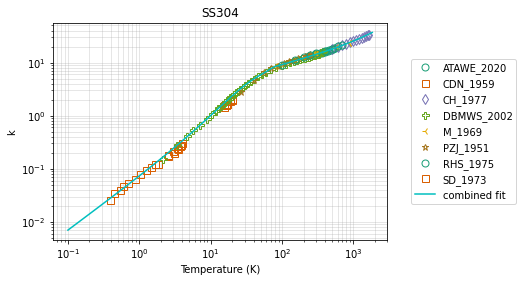

<Figure size 432x288 with 0 Axes>

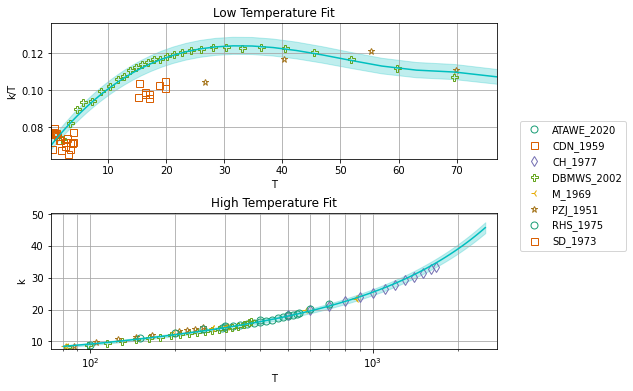

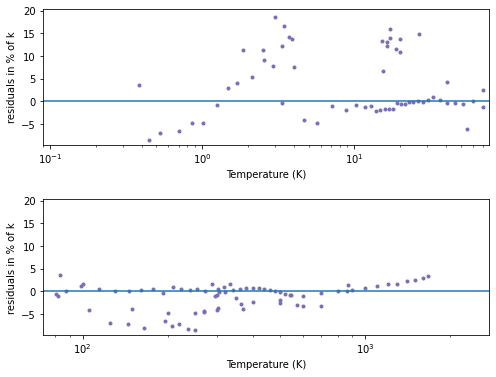

In [7]:
from tc_utils import *

for mat in path_to_RAW.keys():
    erf_locList = np.linspace(50, 100, 10)
    perc_diff_avg = np.array([])
    for erf_loc in erf_locList:
        ## First, let's collect the raw data from their csv files
        big_data, data_dict = parse_raw(mat, path_to_RAW[mat], plots=False, weight_const=0.5)
        ## Now, let's fit that data by way of the fit function described above.
        fit_args = fit_thermal_conductivity(big_data, 
                                            os.path.split(path_to_RAW[mat])[0], 
                                            erf_loc=erf_loc, fit_orders=(3, 3), plots=False)
        ## With the fit complete, let's output a formatted dictionary with the fit parameters
        output_array = make_fit_dict(fit_args)
        ## We want to figure out the best location for the split in data, so we will compute the residual of the combined fit
        Tdata = np.concatenate([(data_dict[ref_name].T[0]) for ref_name in data_dict])
        kdata = np.concatenate([(data_dict[ref_name].T[1]) for ref_name in data_dict])
        low_param, hi_param, erf_param = fit_args["low_fit_param"], fit_args["hi_fit_param"], fit_args["combined_fit_param"][-1]
        kpred = loglog_func(Tdata, low_param, hi_param, erf_param)
        # and append it to the array resVal
        diff = abs(kpred-kdata)
        perc_diff_arr = 100*diff/kpred
        # print((kpred-kpred*perc_diff_arr)[Tdata.argsort()])
        perc_diff_avg = np.append(perc_diff_avg, np.mean(perc_diff_arr))

    # plt.plot(erf_locList, perc_diff_avg)
    # plt.show()
    # Now that we have found the residuals of the fits for many different split locations, let's choose the best one.    
    erf_locdict = dict(zip(erf_locList, perc_diff_avg))
    bestRes = min(erf_locdict.values())
    besterf_loc = [key for key in erf_locdict if erf_locdict[key] == bestRes]
    print(f"Low-Hi split centered at : {besterf_loc[0]} ~~ with average percent difference value of: {bestRes:.2f}%")
    
    # We will repeat the above fit with this new 'optimized' split location
    fit_args = fit_thermal_conductivity(big_data, os.path.split(path_to_RAW[mat])[0], erf_loc=besterf_loc, fit_orders=(3, 3), plots=False)
    output_array = make_fit_dict(fit_args)

    # Finally, we will output the fit parameters as a csv, and lh5 file - and plot the data.
    create_data_table(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.txt")
    create_tc_csv(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.csv")
    make_fit_lh5(fit_args, os.path.split(path_to_RAW[mat])[0])
    # PLOTTING CODE
    tk_plot(mat,path_to_RAW, data_dict, fit_args, fit_range = [100e-3, 25e2], points=True, fits="combined", fill=True)

Finally, lets output a single human readable (and CSV) file of the fits for each material currently in the library.

In [5]:
output_array = compile_csv(path_to_RAW)
create_data_table(output_array, "..\\thermal_conductivity_compilation.txt")
create_tc_csv(output_array, "..\\thermal_conductivity_compilation.csv")

The following cell is an example of what can be done with the output csv file

In [6]:
current_year = 2024
test_year = 1973

print(0.01*(current_year-test_year))


0.51
